# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Стоят задачи:
- 1) Предобработка и иследование данных
- 2) Оцените прибыль отеля без внедрения депозитов
- 3) Оцените прибыль, которую принесёт выбранная модель за год
- 4) описать ненадежного клиента

- id — номер записи;
- adults — количество взрослых постояльцев;
- arrival_date_year — год заезда;
- arrival_date_month — месяц заезда;
- arrival_date_week_number — неделя заезда;
- arrival_date_day_of_month — день заезда;
- babies — количество младенцев;
- booking_changes — количество изменений параметров заказа;
- children — количество детей от 3 до 14 лет;
- country — гражданство постояльца;
- customer_type — тип заказчика:
- Contract — договор с юридическим лицом;
- Group — групповой заезд;
- Transient — не связано с договором или групповым заездом;
- Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list — сколько дней заказ ожидал подтверждения;
- distribution_channel — канал дистрибуции заказа;
- is_canceled — отмена заказа;
- is_repeated_guest — признак того, что гость бронирует номер второй раз;
- lead_time — количество дней между датой бронирования и датой прибытия;
- meal — опции заказа:
- SC — нет дополнительных опций;
- BB — включён завтрак;
- HB — включён завтрак и обед;
- FB — включён завтрак, обед и ужин.
- previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
- previous_cancellations — количество отменённых заказов у клиента;
- required_car_parking_spaces — необходимость места для автомобиля;
- reserved_room_type — тип забронированной комнаты;
- stays_in_weekend_nights — количество ночей в выходные дни;
- stays_in_week_nights — количество ночей в будние дни;
- total_nights — общее количество ночей;
- total_of_special_requests — количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [1]:
# подключение библиотек
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, make_scorer, fbeta_score


In [2]:
# подгрузка файлов тренировочных 
pd.set_option('display.max_columns', 50) 

pth1 = '/datasets/hotel_train.csv'
pth2 = 'hotel_train.csv'

if os.path.exists(pth1):
    df_train = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_train = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
# подгрузка файлов тестовых
pth1 = '/datasets/hotel_test.csv'
pth2 = 'hotel_test.csv'

if os.path.exists(pth1):
    df_test = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df_test = pd.read_csv(pth2)
else:
    print('Something is wrong')

#### Вывод
- были подгружены нужные библиотеке
- были подгруженны данные

### Шаг 2. Предобработка и исследовательский анализ данных

In [4]:
# Общая информация по тренировочным файлам
df_train.info()
display(df_train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [5]:
df_test.info()
display(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [6]:
# Преобразования чисел с плав. точкой в целочис. вид
def float_in_int (df,colum):
    for _ in colum:
        df[_] = df[_].astype('int')
        
col = ['lead_time','adults','children','babies']

float_in_int(df_train,col)
float_in_int(df_test,col)

In [7]:
# преобразования столбца month к категориальному виду при помощи цифр
print('Столбец до преобразования \n {0}'.format(df_train['arrival_date_month'].head()))

month = {'January':1, 'February':2, 'March':3,
         'April':4, 'May':5,'June':6, 'July':7,
         'August':8, 'September': 9, 'October':10,
         'November':11, 'December':12 }
df_train['arrival_date_month'] = df_train['arrival_date_month'].apply(lambda x: month[x])
df_test['arrival_date_month'] = df_test['arrival_date_month'].apply(lambda x: month[x])

print('Столбец после преобразования \n {0}'.format(df_train['arrival_date_month'].head()))

Столбец до преобразования 
 0    July
1    July
2    July
3    July
4    July
Name: arrival_date_month, dtype: object
Столбец после преобразования 
 0    7
1    7
2    7
3    7
4    7
Name: arrival_date_month, dtype: int64


In [8]:
# преобразования столбца meal  к категориальному виду при помощи цифр
print('Столбец до преобразования \n {0}'.format(df_train['meal'].head()))

meal = {'SC':0,'BB':1,
        'HB':2,'FB':3}
df_train['meal'] = df_train['meal'].str.strip().apply(lambda x: meal[x])
df_test['meal'] = df_test['meal'].str.strip().apply(lambda x: meal[x])

print('Столбец после преобразования \n {0}'.format(df_train['meal'].head()))

Столбец до преобразования 
 0    BB       
1    BB       
2    BB       
3    FB       
4    BB       
Name: meal, dtype: object
Столбец после преобразования 
 0    1
1    1
2    1
3    3
4    1
Name: meal, dtype: int64


In [9]:
# преобразования столбца reserved_room_type  к категориальному виду при помощи цифр
print('Столбец до преобразования \n {0}'.format(df_train['reserved_room_type'].head()))

room_type = {'A':0, 'B':1, 'C':2,
            'D':3, 'E':4, 'F':5, 'G':6}
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip().apply(lambda x: room_type[x])
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip().apply(lambda x: room_type[x])

print('Столбец до преобразования \n {0}'.format(df_train['reserved_room_type'].head()))

Столбец до преобразования 
 0    A               
1    A               
2    C               
3    C               
4    A               
Name: reserved_room_type, dtype: object
Столбец до преобразования 
 0    0
1    0
2    2
3    2
4    0
Name: reserved_room_type, dtype: int64


In [10]:
# преобразования столбца reserved_room_type  к категориальному виду при помощи цифр
print('Столбец до преобразования \n {0}'.format(df_train['customer_type'].head()))

customer_type = {'Contract':0, 'Group':1,
                 'Transient':2, 'Transient-Party':3}
df_train['customer_type'] = df_train['customer_type'].str.strip().apply(lambda x: customer_type[x])
df_test['customer_type'] = df_test['customer_type'].str.strip().apply(lambda x: customer_type[x])

print('Столбец до преобразования \n {0}'.format(df_train['customer_type'].head()))

Столбец до преобразования 
 0    Transient
1    Transient
2    Transient
3    Transient
4    Transient
Name: customer_type, dtype: object
Столбец до преобразования 
 0    2
1    2
2    2
3    2
4    2
Name: customer_type, dtype: int64


In [11]:
# явные дубликаты
print('Колличество явных дубликатов в тренировочной выборке: {0}'.format(df_train.drop('id',axis=1).duplicated().sum()))
print('Колличество явных дубликатов в тестовой выборке: {0}'.format(df_test.drop('id',axis=1).duplicated().sum()))

Колличество явных дубликатов в тренировочной выборке: 21377
Колличество явных дубликатов в тестовой выборке: 7717


In [12]:
df_train = df_train.drop(['id'],axis=1)
df_test = df_test.drop(['id'],axis=1)
df_train = df_train.drop_duplicates(keep='first')
df_test = df_test.drop_duplicates(keep='first')


Статистическая характеристика расположения данных в столбцах


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000,43852.000000
mean,0.254219,67.893779,2015.775518,7.382902,31.091216,15.919274,0.896014,2.312141,1.856289,0.107589,0.010695,0.972476,0.032929,0.041640,0.154748,1.022850,0.249453,0.821354,2.053430,0.082368,0.670847,3.208155
std,0.435426,73.990715,0.417246,3.183014,13.894327,8.859208,0.867677,1.454810,0.504892,0.397146,0.120050,0.444697,0.178453,0.459333,1.583894,1.640233,0.679791,9.902211,0.564626,0.276086,0.802964,1.877202
min,0.000000,0.000000,2015.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,9.000000,2016.000000,5.000000,20.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000
50%,0.000000,41.000000,2016.000000,8.000000,33.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,3.000000
75%,1.000000,103.000000,2016.000000,10.000000,43.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,4.000000
max,1.000000,374.000000,2016.000000,12.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,3.000000,1.000000,26.000000,58.000000,6.000000,17.000000,259.000000,3.000000,3.000000,5.000000,10.000000


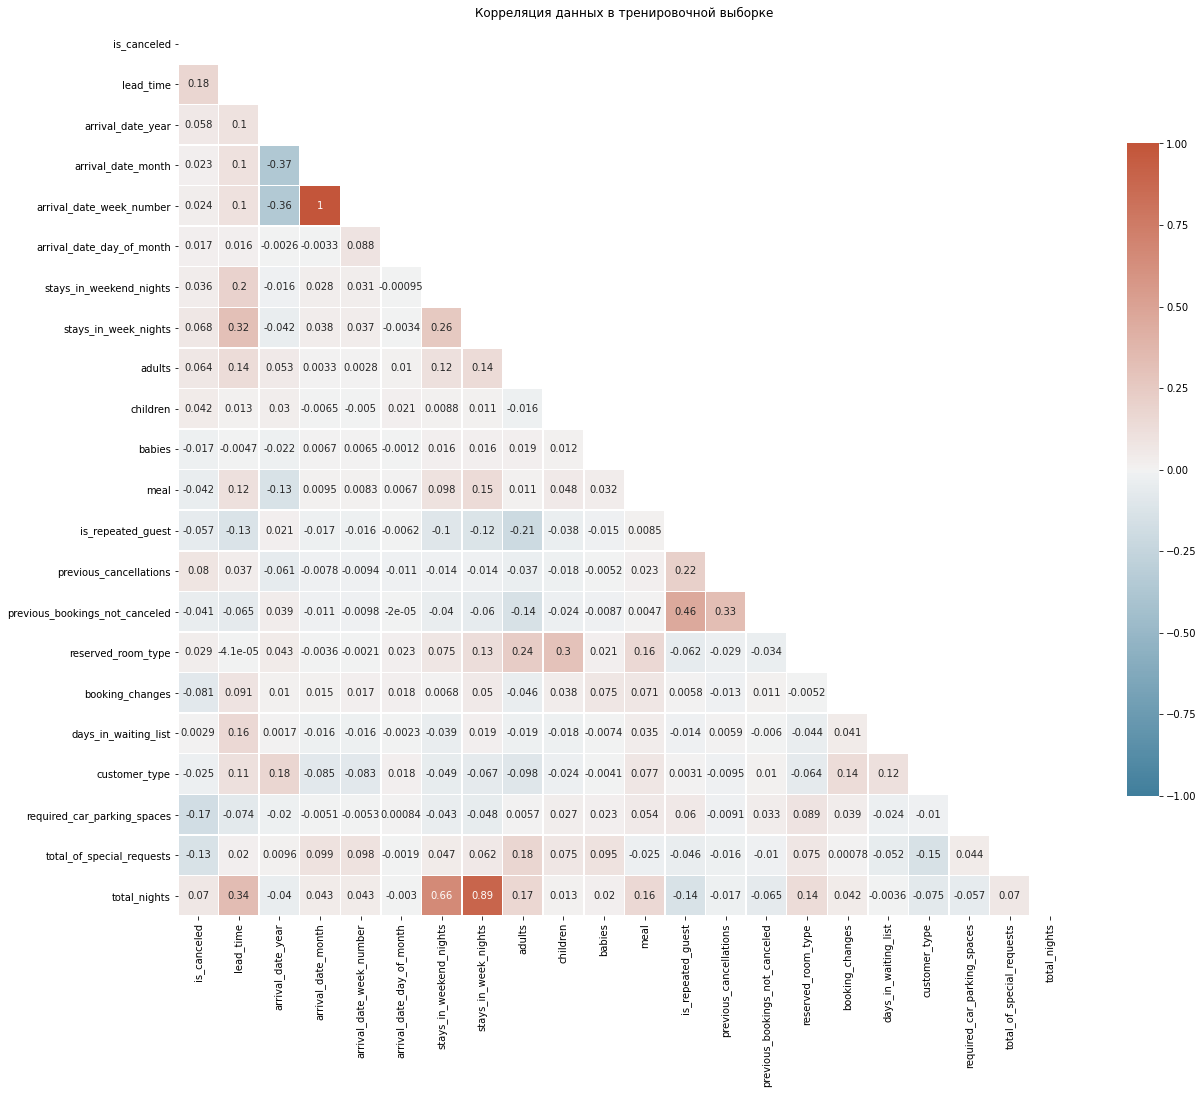

In [13]:
#основные характеристики столбцов В тренировочной выборке
print('Статистическая характеристика расположения данных в столбцах')
display(df_train.describe())
#print('Корреляция данных')
#display(df_train.drop(['id'],axis=1).corr())

plt.figure(figsize=(20, 20))
corr_train = df_train.corr()

mask = np.triu(np.ones_like(corr_train, dtype=bool))
cmap = sb.diverging_palette(230, 20, as_cmap=True)
sb.heatmap(corr_train, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True)
plt.title('Корреляция данных в тренировочной выборке')
plt.show()

Статистическая характеристика расположения данных в столбцах


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
count,24695.000000,24695.000000,24695.0,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000,24695.000000
mean,0.315246,88.834541,2017.0,4.610083,18.192833,15.579348,0.910306,2.379186,1.887265,0.106054,0.007208,0.895768,0.040535,0.015104,0.223527,1.089006,0.254343,0.341486,2.057340,0.059567,0.763272,3.289492
std,0.464623,85.506551,0.0,2.164066,9.438886,8.776695,0.859874,1.426038,0.495552,0.384630,0.086488,0.501222,0.197213,0.206339,2.144022,1.639622,0.698303,5.404491,0.384713,0.247559,0.861233,1.818364
min,0.000000,0.000000,2017.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,16.000000,2017.0,3.000000,10.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000
50%,0.000000,63.000000,2017.0,5.000000,18.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,3.000000
75%,1.000000,143.000000,2017.0,6.000000,26.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,4.000000
max,1.000000,373.000000,2017.0,8.000000,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,2.000000,3.000000,1.000000,6.000000,72.000000,6.000000,18.000000,223.000000,3.000000,8.000000,5.000000,10.000000


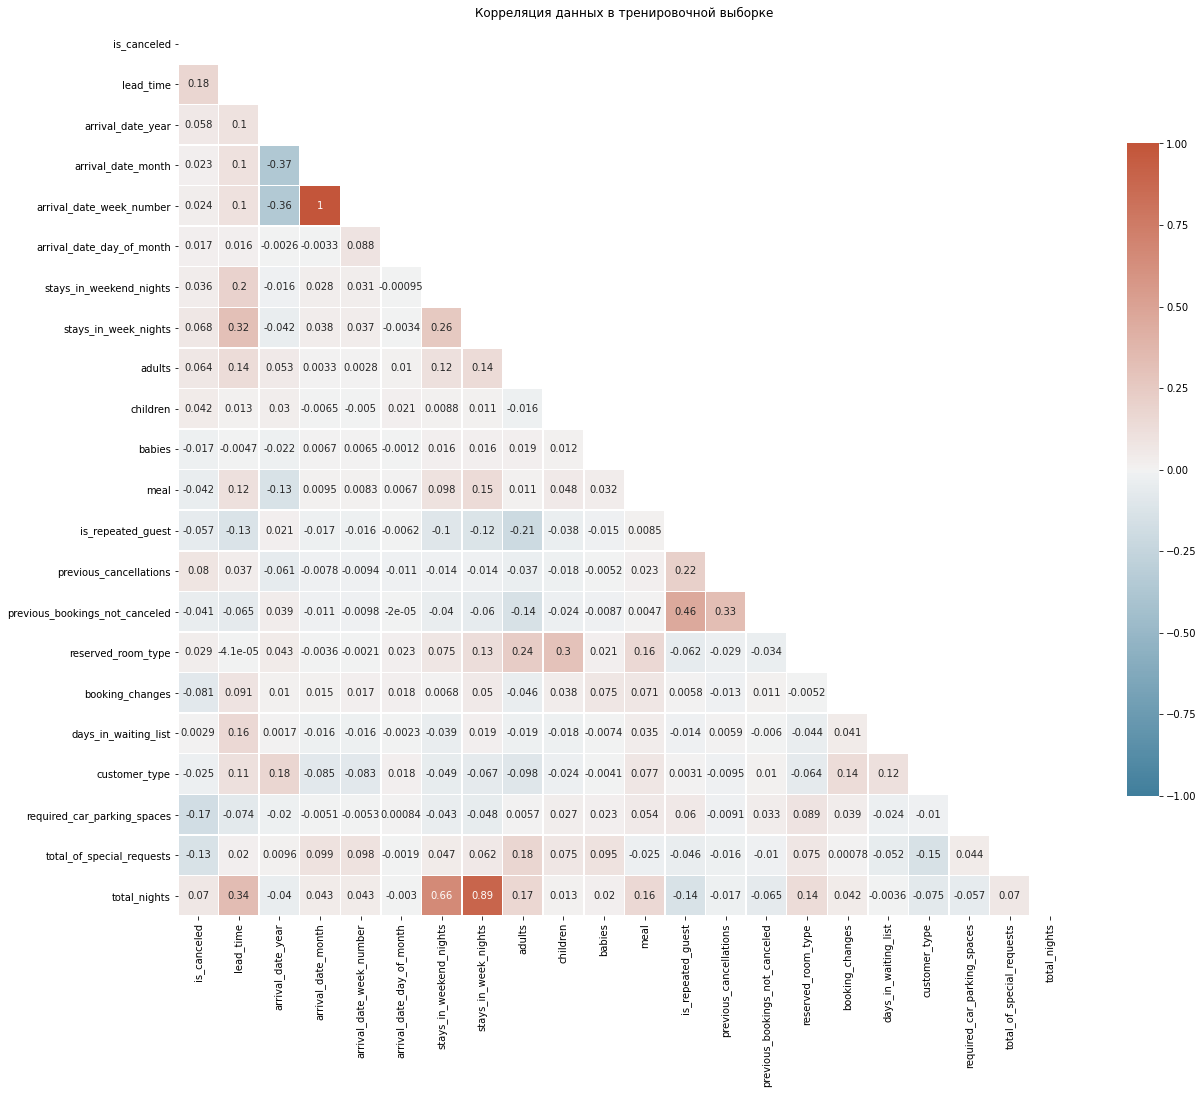

In [14]:
#основные характеристики столбцов В тренировочной выборке
print('Статистическая характеристика расположения данных в столбцах')
display(df_test.describe())
#print('Корреляция данных')
#display(df_test.drop(['id'],axis=1).corr())

plt.figure(figsize=(20, 20))
corr_test = df_train.corr()

mask = np.triu(np.ones_like(corr_train, dtype=bool))
cmap = sb.diverging_palette(230, 20, as_cmap=True)

sb.heatmap(corr_test, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True)
plt.title('Корреляция данных в тренировочной выборке')
plt.show()

Большая корреляция месяца и номер недели связанна с тем, что недели включают себя месяц 

Из данных удаляються следующие столбцы:
- id не несет какой либо информации просто очередь
- arrival_date_year - год не интересен для обучения так как обучение данных с 2015 и 2016 года, а предсказуем в 2017 году
- arrival_date_week_number - номер недели указывает теже саммые значения что и месяц заеда (по графикам внизу указаны, т.е. две колонки указывающий на один параметр не обязательны + еще они корррелируемые между собой полностью что говорит о правильности уборки одного из параметра)
- arrival_date_day_of_month - день не имеет значения для данного обучения и не имеет корреляции с годом, а также в данном исследование интересно зарабатная плата за месяц или год
- total_nights - колличество всего ночей это тоже самое что и кол-во ночей в будни + кол-во ночей в выходные (сумма будних и выходных)

In [15]:
#drop_col = ['arrival_date_year','arrival_date_week_number',
#           'arrival_date_day_of_month', 'distribution_channel', 'total_nights']
#df_train = df_train.drop(drop_col,axis=1)
#df_test = df_test.drop(drop_col,axis=1)


In [16]:
def hist_and_box(df,col):
    fig, axs = plt.subplots(ncols=2,figsize=(20,5))
    sb.set(font_scale=1.10)
    distplot = sb.distplot(df[col],ax=axs[0],kde=False).set_title(f'DataFrame column {col}',fontsize=20);
    sb.boxplot(df[col], ax=axs[1]).set_title(f'DataFrame parametr {col}',fontsize=20);
    plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


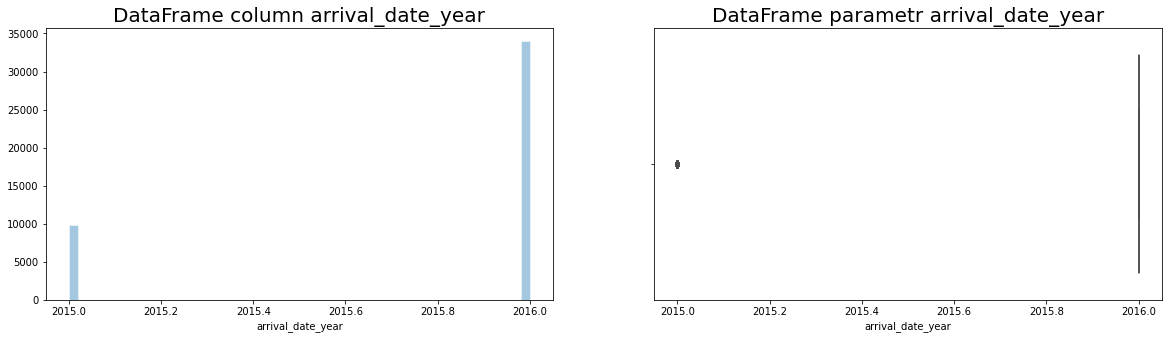

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


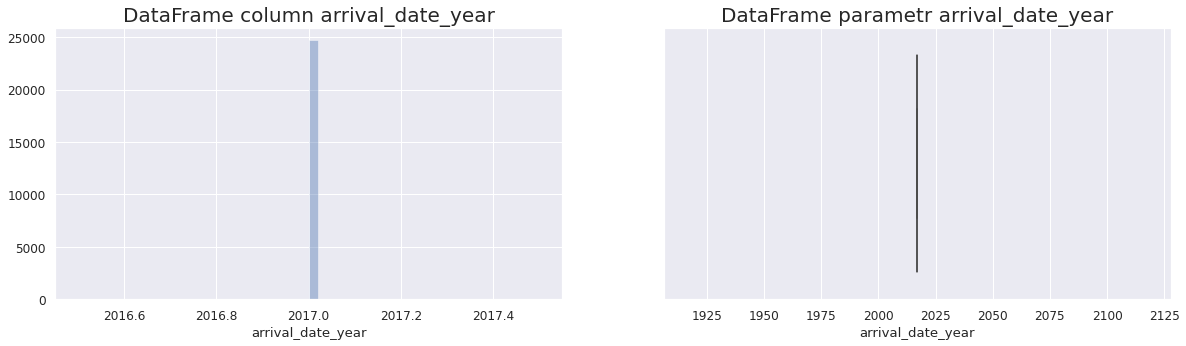

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


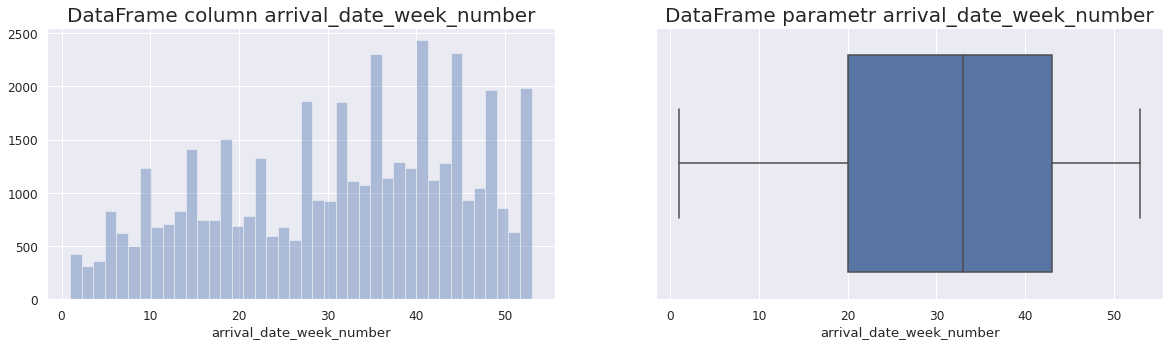

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


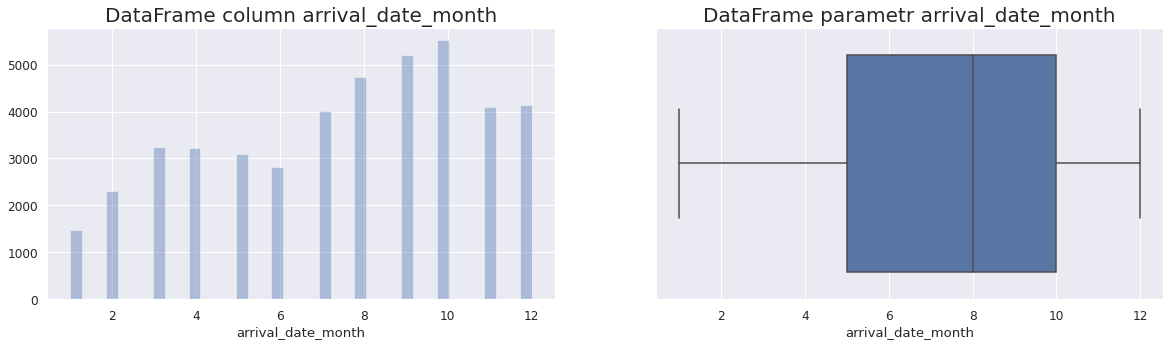

Колличество посетителей по неделям 2972
Колличество посетителей по месяцам 3086
9781
9781


In [17]:
## Доказательство того что год не имеет значения
hist_and_box(df_train,'arrival_date_year')
hist_and_box(df_test,'arrival_date_year')

## Доказательство того что месяц и неделя указывают одни значения
hist_and_box(df_train,'arrival_date_week_number')
hist_and_box(df_train,'arrival_date_month')
print('Колличество посетителей по неделям',
     df_train.query('18 <= arrival_date_week_number <= 21 & arrival_date_year == 2016')['adults'].count())
print('Колличество посетителей по месяцам',
     df_train.query('arrival_date_month == 5 & arrival_date_year == 2016')['adults'].count())

## доказательство равенство ночей будние и в выходные с тотальным 
print(df_train.query('arrival_date_month == 5 & arrival_date_year == 2016')['total_nights'].sum())
print(df_train.query('arrival_date_month == 5 & arrival_date_year == 2016')['stays_in_week_nights'].sum() +
     df_train.query('arrival_date_month == 5 & arrival_date_year == 2016')['stays_in_weekend_nights'].sum())

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


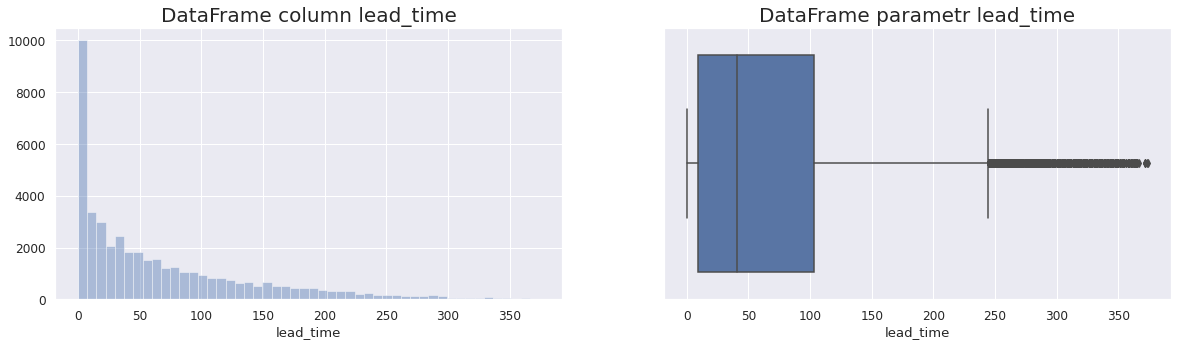

In [18]:
hist_and_box(df_train,'lead_time')

In [19]:
# Судя по картинке выше выброс выше 350
def filter_outlier (df,column):
    q_1 = df[column].quantile(q=0.25)
    q_3 = df[column].quantile(q=0.75)
    iqr = q_3 - q_1
    high = iqr * 1.5 + q_3
    low = q_1 - iqr * 1.5
    df_out = df.loc[(df[column] > low) & (df[column] < high)]
    hist_and_box(df_out,column)
    return df_out

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


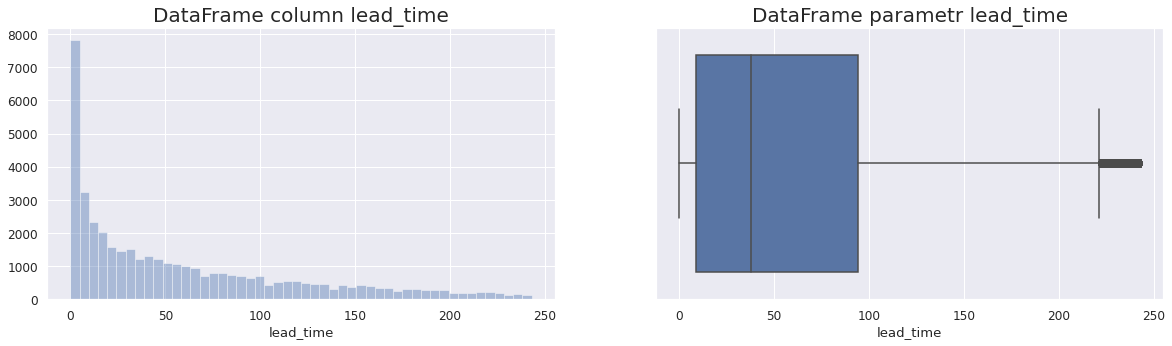

In [20]:
df_train = filter_outlier(df_train,'lead_time')

(42280, 24)


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


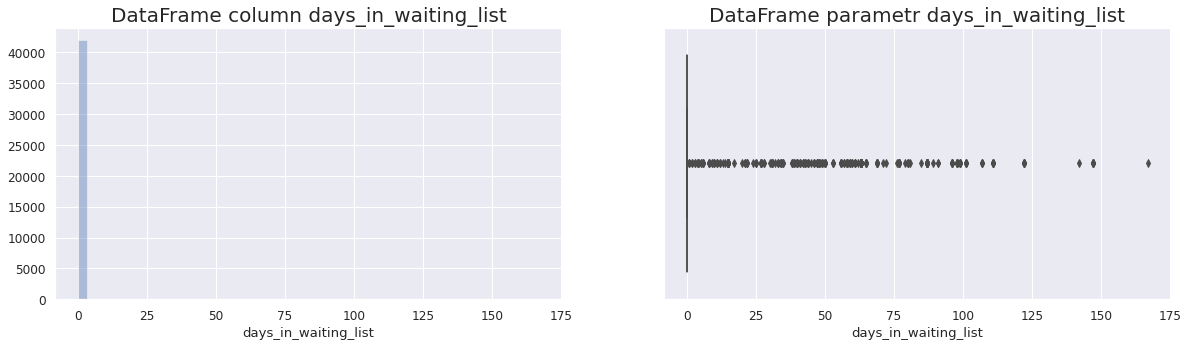

(42131, 24)


In [21]:
print(df_train.shape)
hist_and_box( df_train,'days_in_waiting_list')
df_train = df_train.query('days_in_waiting_list < 60')
print(df_train.shape)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


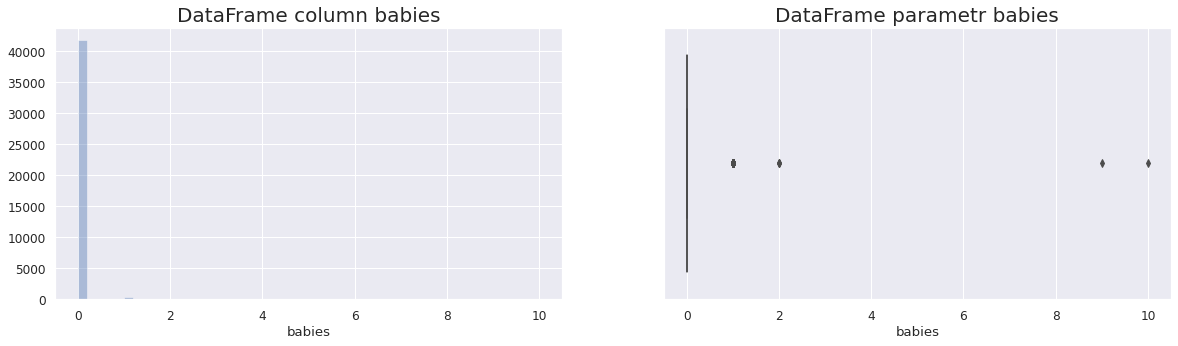

(42126, 24)

In [22]:
hist_and_box(df_train,'babies')
df_train = df_train.query('babies < 2')
df_train.shape

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


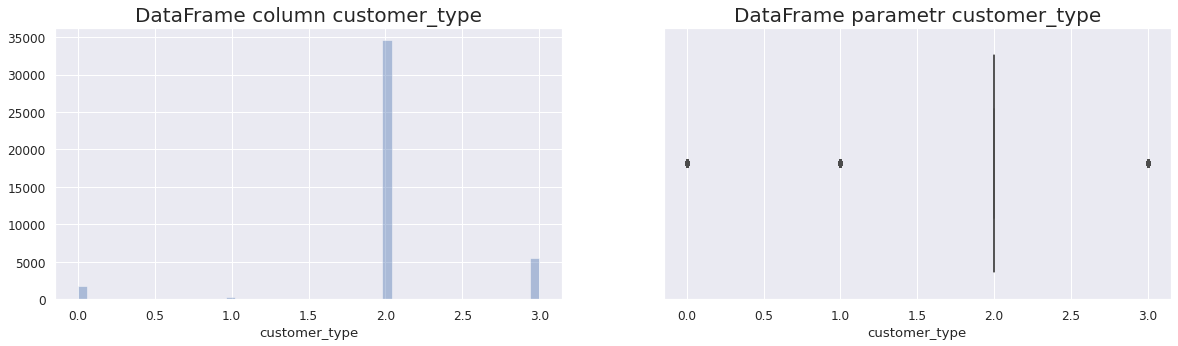

In [23]:
hist_and_box(df_train,'customer_type')

(42126, 24)


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


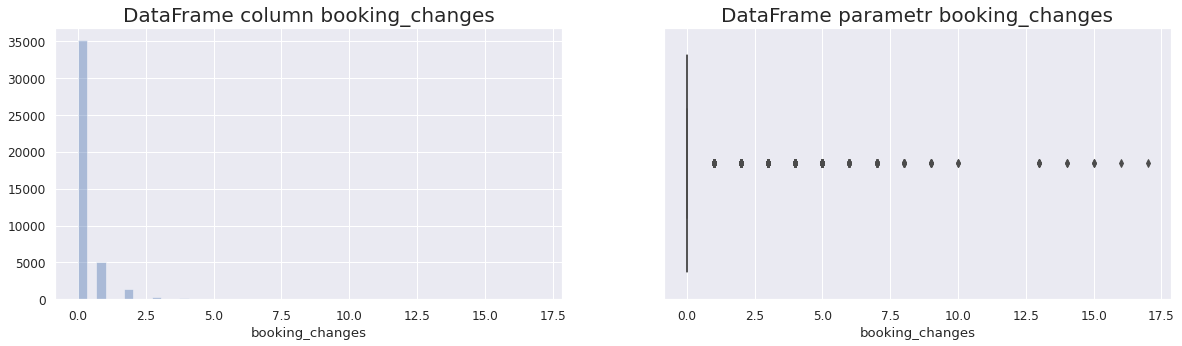

None
(41908, 24)


In [24]:
print(df_train.shape)
print(hist_and_box(df_train,'booking_changes'))
df_train = df_train.query('booking_changes < 4')
print(df_train.shape)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


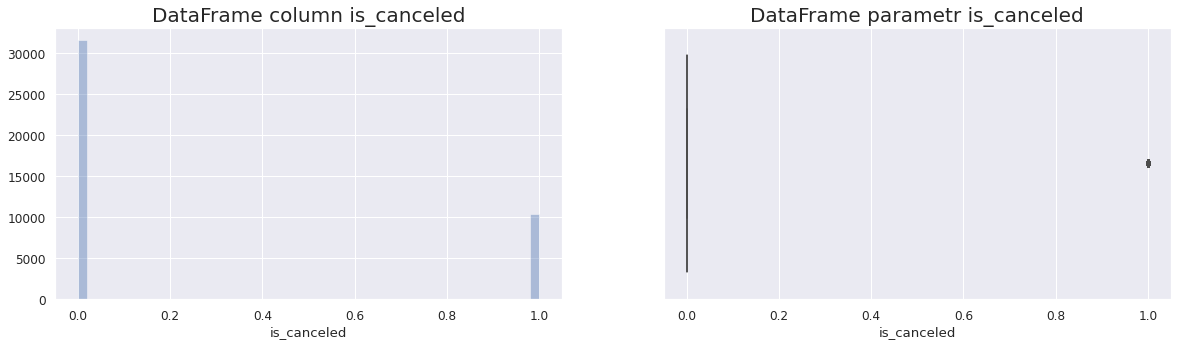

In [25]:
hist_and_box(df_train,'is_canceled')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


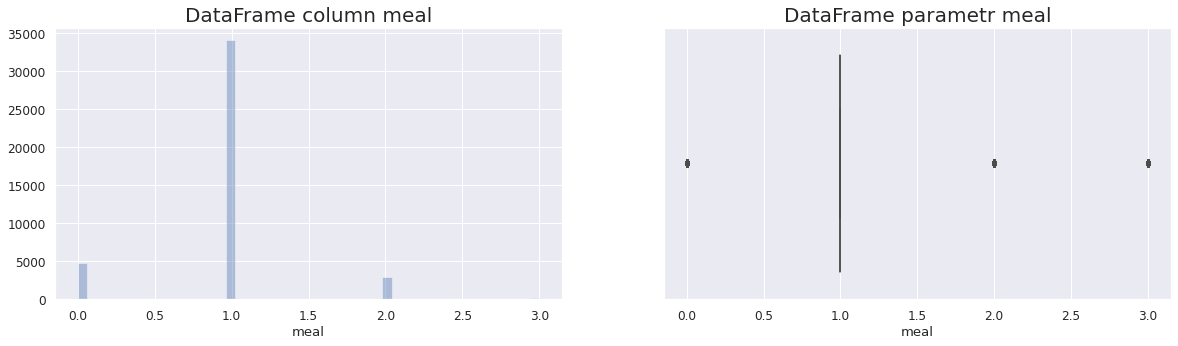

In [26]:
hist_and_box(df_train,'meal')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


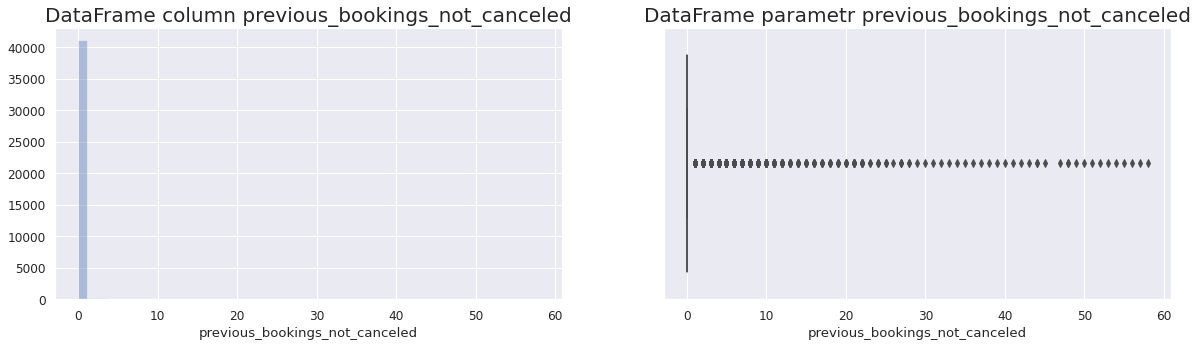

(41768, 24)


37255

In [27]:
hist_and_box(df_train,'previous_bookings_not_canceled')
df_train = df_train.query('previous_bookings_not_canceled <=10')
print(df_train.shape)
df_train['stays_in_weekend_nights'].sum()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


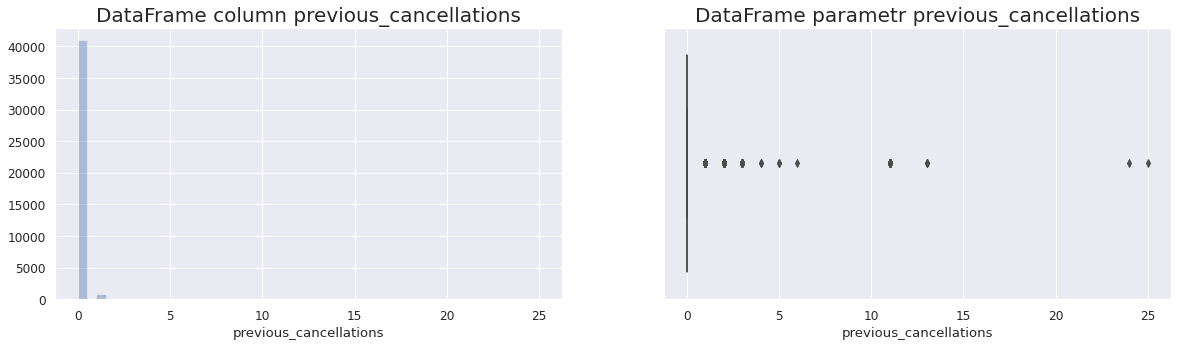

(41694, 24)


In [28]:
hist_and_box(df_train,'previous_cancellations')
df_train = df_train.query('previous_cancellations <=1')
print(df_train.shape)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


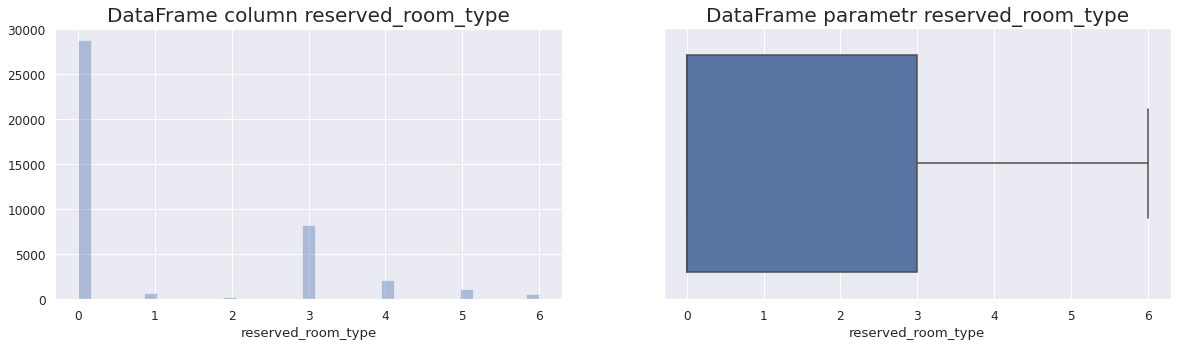

37210

In [29]:
hist_and_box(df_train,'reserved_room_type')
df_train['stays_in_weekend_nights'].sum()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


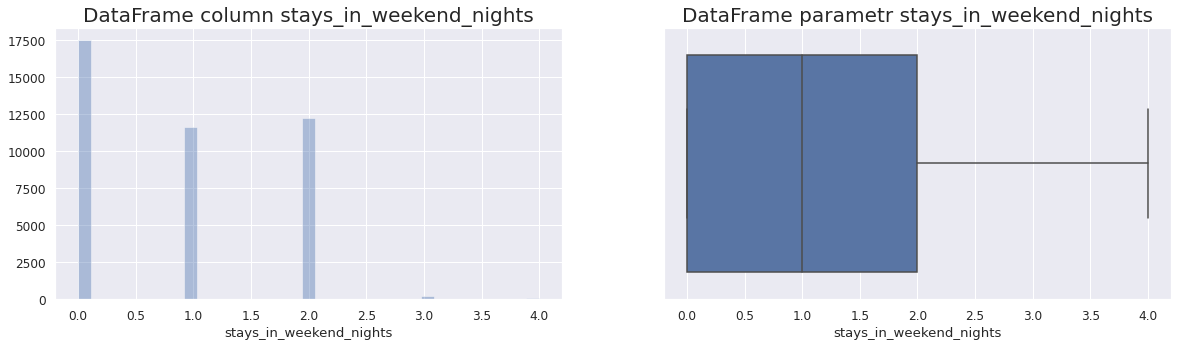

In [30]:
hist_and_box(df_train,'stays_in_weekend_nights')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


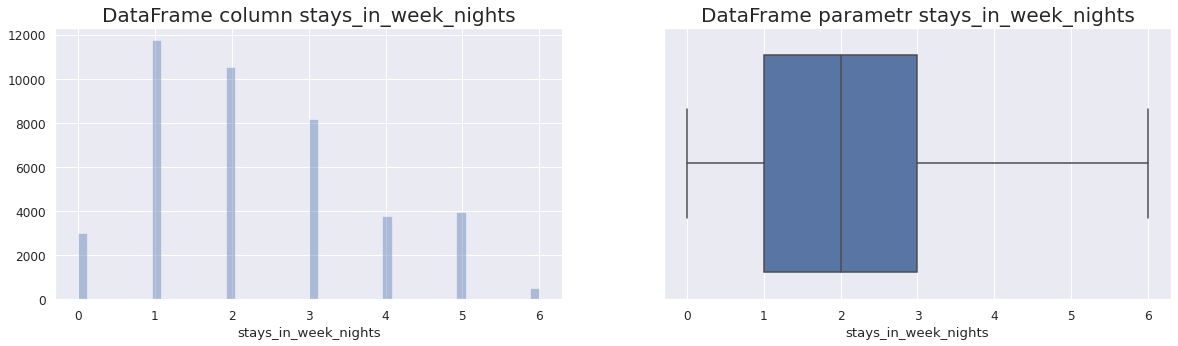

37210

In [31]:
hist_and_box(df_train,'stays_in_week_nights')
df_train['stays_in_weekend_nights'].sum()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


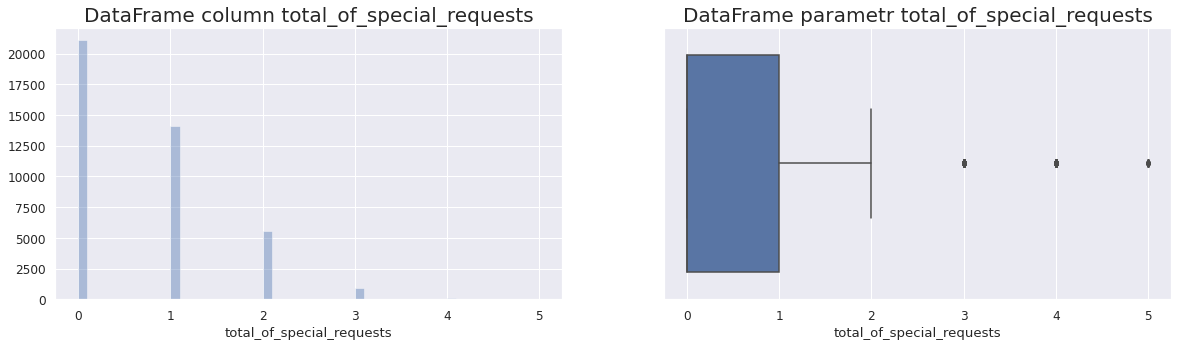

37210

In [32]:
hist_and_box(df_train,'total_of_special_requests')
df_train['stays_in_weekend_nights'].head()
df_train['stays_in_weekend_nights'].sum()

#### ВЫВОД
В данном пункте:
- Проверяна общая информация о датасете
- Преобразованы 4 колонки в целочисленный тип данных 
- Преобразованы категории для месяца и других столбцов в цифренный формат 
- Не было выявленно прямых дубликатов c id, убрав id получаеться:
    - Колличество явных дубликатов в тренировочной выборке: 19713
    - Колличество явных дубликатов в тестовой выборке: 7717
- Корелируемыми значениями являються год, номер недели и месяц (что логично)
    - А также is_repeated_guest и previous_bookings_not_canceled что говорит о постоянных клиентах (все скорее)
    - Остальные имееют маленькое значение корреляции (дубликаты могут влиять на даные значения )
- Создана функция для показания графиков
- Удалены выбросы (где это можно было)

In [33]:
print(df_train.shape)
#print(df_train.query('babies>0 & adults==0')['adults'].count()) # не адекватность 
df_train.drop(df_train.query('babies>0 & adults==0 & children >0').index, inplace=True)
df_test.drop(df_test.query('babies>0 & adults==0 & children >0').index, inplace=True)

print(df_train.shape)


(41694, 24)
(41691, 24)


### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [34]:
columns = ['reserved_room_type' , 'room_price', 'room_prepare']
data = [[0, 1000, 400],[1, 800, 350], [2, 600, 350], [3, 550, 150], 
        [4, 500, 150], [5, 450, 150], [6, 350, 150]]
room_data = pd.DataFrame(data=data, columns = columns)

In [35]:
def get_season_coefficient(value):
    if value in ['June', 'July', 'August']:
        return 1.4
    if value in ['December', 'January', 'February']:
        return 1
    else:
        return 1.2

In [36]:
# функция для подсчета без депозитов
def count_revenue(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()   
    total_nights = week_nights + weekend_nights
    coeff = get_season_coefficient(row['arrival_date_month'])
    if (row['is_canceled'] == 0): 
        prepare_nights = math.floor((total_nights/2))
        if (month in ['June', 'July', 'August']):
            revenue = coeff*price*total_nights - prepare_cost - prepare_nights*prepare_cost
        elif (month in ['December', 'January', 'February']):
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost
        else:
            revenue = coeff * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    else:
        if (month in ['June', 'July', 'August']):
            revenue = - prepare_cost -coeff* price
        elif (month in ['December', 'January', 'February']):
            revenue = - prepare_cost -  price
        else:
            revenue = - prepare_cost - coeff* price
    return revenue

In [37]:
revenue_not_deposit = df_test.apply(count_revenue, axis=1).sum()
print(f'Прибыль без внедрения депозитов {revenue_not_deposit/10**6:.3} млн.')

Прибыль без внедрения депозитов 31.5 млн.


### Шаг 4. Разработка модели ML

In [38]:
# Убираються значения которые не нужны для обучения модели 
columns_features = ['total_nights', 'arrival_date_day_of_month', 
                    'arrival_date_week_number', 'arrival_date_year']
hotel_train_ohe = df_train.drop(columns_features,axis=1)
hotel_test_ohe = df_test.drop(columns_features,axis=1)

target_train = hotel_train_ohe['is_canceled']
target_test = hotel_test_ohe['is_canceled']
features_train = hotel_train_ohe.drop('is_canceled', axis=1)
features_test = hotel_test_ohe.drop('is_canceled', axis=1)

In [39]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(features_train)
features_train = enc.transform(features_train) 
features_test = enc.transform(features_test)

In [40]:
#from sklearn.metrics import precision_score,recall_score
#scoring = {'Accuracy':'accuracy', 
#               'precision': make_scorer(precision_score, average='weighted'),
#               'recall': make_scorer(recall_score, average='weighted'),
#               'f1': make_scorer(f1_score, average='weighted')}

col = ['max_depth', 'min_samples_leaf', 'final_score']
data = []

for depth in range(1, 10):
    for _ in range(1,10):
        model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced',
                                  min_samples_leaf =_ )
        scores = cross_val_score(model,features_train, target_train, cv=5 , scoring='f1')
        final_score = sum(scores)/len(scores)
        data.append([depth, _, final_score])
table = pd.DataFrame(data = data, columns=col)

print('Лучшее значение полученные при обучении решающего дерева ')
display(table[table['final_score'] == table['final_score'].max()])

Лучшее значение полученные при обучении решающего дерева 


,max_depth,min_samples_leaf,final_score
44,5,9,0.502414


In [41]:
col = ['n_estimators', 'final_score', 'max_depth']
data = []

for est in range(1, 10):
    for depth in range(1,10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est,max_depth=depth ,class_weight='balanced') 
        scores = cross_val_score(model,features_train, target_train, cv=5, scoring='f1')
        final_score = sum(scores)/len(scores)
        data.append([est, final_score, depth])
        
table = pd.DataFrame(data = data, columns=col)
print('Лучшее значение полученные при обучении решающего леса ')
display(table[table['final_score']==table['final_score'].max()]) 

Лучшее значение полученные при обучении решающего леса 


,n_estimators,final_score,max_depth
40,5,0.450661,5


In [42]:
print(f'Лучшая модель являться модель решающего дерева, при глубине 5' )

Лучшая модель являться модель решающего дерева, при глубине 5


Значение F1-меры на тестовой выборке: 0.533
Значение метрики AUC-ROC: 0.696


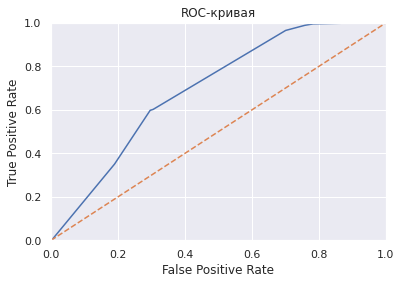

In [43]:
model =  DecisionTreeClassifier(random_state=12345, max_depth=5,
                                class_weight='balanced', min_samples_leaf = 6)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
test_f1_score = f1_score(target_test, predicted_test )
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print(f'Значение F1-меры на тестовой выборке: {test_f1_score:.3}') 
print(f'Значение метрики AUC-ROC: {auc_roc:.3}')

sb.set(font_scale=1)
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Как видно из графика модель имеет больше правильных ответов чем просто рандомное решение

In [44]:
# gПроверка адекватности 
names = ['stratified', 'most_frequent', 'prior', 'uniform']
data = []
col = ['name',  'f1_score_test', 'auc_roc_test']

for name in names:
    new_dummy_classifier = DummyClassifier(strategy=name)
    new_dummy_classifier.fit(features_train, target_train)
    test_predictions = new_dummy_classifier.predict(features_test)
    probabilities_test = new_dummy_classifier.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]
    test_accuracy = accuracy_score(target_test, test_predictions)
    test_f1_score = f1_score(target_test, test_predictions )
    auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
    data.append([name, test_f1_score, auc_roc_test])
    
table = pd.DataFrame(data = data, columns=col)
display(table[table['f1_score_test']==table['f1_score_test'].max()]) 

,name,f1_score_test,auc_roc_test
3,uniform,0.389916,0.5


Как видно из таблице выше модель при балансе имеет лучше значения чем у 'stratified', 'most_frequent', 'prior', 'uniform', а так же максимальное значения f1 у uniform 

In [45]:
#добавление колонки предсказания
model =  DecisionTreeClassifier(random_state=12345, max_depth=5,
                                class_weight='balanced',min_samples_leaf = 6)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
df_test['predictions'] = predicted_test
display(df_test.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
0,1,74,2017,1,1,1,1,0,2,0,0,1,PRT,TA/TO,0,0,0,0,0,0,2,0,0,1,1
1,1,62,2017,1,1,1,2,2,2,0,0,1,AUT,TA/TO,0,0,0,0,0,0,2,0,1,4,0
3,1,71,2017,1,1,1,2,2,1,0,0,1,PRT,TA/TO,0,0,0,0,0,0,2,0,1,4,1
4,1,172,2017,1,1,1,2,5,2,0,0,1,BEL,TA/TO,0,0,0,0,0,0,2,0,0,7,1
5,1,52,2017,1,1,1,2,5,1,0,0,1,DEU,TA/TO,0,0,0,0,0,0,2,0,0,7,1


In [46]:
def deposit (coef, pric, service):
    dep = 0.8 * (coef * pric + service)
    return dep

In [47]:
# функция для подсчета прибыли при внедрения дипозитов 
#def count_revenue_with_deposit(row):
#    room_type = row['reserved_room_type']
#    month = row['arrival_date_month']
#    week_nights = row['stays_in_week_nights']
#    weekend_nights = row['stays_in_weekend_nights']
#    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
#    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
#    total_nights = week_nights + weekend_nights
#    coeff = get_season_coefficient(row['arrival_date_month']) 
#    if (row['is_canceled'] == 0 and row['predictions']==0) or (row['is_canceled'] == 0 and row['predictions']==1):
#        prepare_nights = math.floor((total_nights+1)//2)
#        if (month in ['June', 'July', 'August']):
#            revenue = coeff * price * total_nights - prepare_cost - prepare_nights * prepare_cost
#        elif (month in ['December', 'January', 'February']):
#            revenue = price * total_nights - prepare_cost - prepare_nights * prepare_cost
#        else:
#            revenue = coeff * price * total_nights - prepare_cost - prepare_nights * prepare_cost
#            
#    elif (row['is_canceled'] == 1 and row['predictions']==0):
#        if (month in ['June', 'July', 'August']):
#            revenue = - prepare_cost - coeff * total_nights
#        elif (month in ['December', 'January', 'February']):
#            revenue = - prepare_cost - total_nights
#        else:
#            revenue = - prepare_cost - coeff * total_nights
#            
#    else:
#        if (month in ['June', 'July', 'August']):
#            revenue =  - (prepare_cost - coeff * price) + deposit(coeff,price,prepare_cost)
#        elif (month in ['December', 'January', 'February']):
#            revenue =  - (prepare_cost - price) + deposit(coeff,price,prepare_cost)
#        else: 
#            revenue =  - (prepare_cost - coeff * price)  + deposit(coeff,price,prepare_cost)
#   
#    return revenue

In [48]:
# функция для подсчета прибыли при внедрения дипозитов 
def count_revenue_with_deposit(row):
    room_type = row['reserved_room_type']
    month = row['arrival_date_month']
    week_nights = row['stays_in_week_nights']
    weekend_nights = row['stays_in_weekend_nights']
    price = room_data[room_data['reserved_room_type'] == room_type]['room_price'].median()
    prepare_cost = room_data[room_data['reserved_room_type'] == room_type]['room_prepare'].median()
    total_nights = week_nights + weekend_nights
    coeff = get_season_coefficient(row['arrival_date_month'])
    if (row['is_canceled'] == 0):
        prepare_nights = math.floor((total_nights)/2)       
        if (month in ['June', 'July', 'August']):
            revenue = coeff * price*total_nights - prepare_cost - prepare_nights*prepare_cost
        elif month in ['December', 'January', 'February']:
            revenue = price*total_nights - prepare_cost - prepare_nights*prepare_cost
        else:
            revenue = coeff * price*total_nights - prepare_cost - prepare_nights*prepare_cost
    else:
        revenue = - (prepare_cost + coeff * price)
        if (row['predictions'] == 1):
            revenue = revenue * 0.2
    return revenue
    

In [49]:
total_revenue_deposit = df_test.apply(count_revenue_with_deposit, axis=1).sum()
print(f'Прибыль от внедрения депозитов {total_revenue_deposit/10**6:.3} млн.')

Прибыль от внедрения депозитов 36.3 млн.


In [50]:
IMPLEMENTATION_COST = 400_000
profit = total_revenue_deposit - revenue_not_deposit - IMPLEMENTATION_COST
print(f'Чистая прибыль при внедрения депозитов {profit/10**6:.3} млн.')

Чистая прибыль при внедрения депозитов 4.48 млн.


#### вывод
Лучшая модель для решения данной задачи являеться решающее дерево,прибыль принесенная данной моделью составляет 4.66 млн

### Шаг 5. Опишите портрет «ненадёжного» клиента

In [51]:
print('Таблица описательной статистики')
display(df_test.query('is_canceled==1 and predictions==True').describe())

Таблица описательной статистики


,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
count,4659.0,4659.000000,4659.0,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.000000,4659.0,4659.000000,4659.000000,4659.000000,4659.000000,4659.0,4659.000000,4659.000000,4659.0
mean,1.0,113.285469,2017.0,4.796952,18.966302,15.518352,0.965443,2.515561,1.973385,0.138656,0.002790,0.885383,0.000215,0.000215,0.0,1.216999,0.135866,1.003649,2.033698,0.0,0.170637,3.481005,1.0
std,0.0,85.838546,0.0,2.087909,9.128627,8.649032,0.866513,1.411145,0.479887,0.449805,0.052755,0.515287,0.014651,0.014651,0.0,1.706176,0.489257,8.510834,0.297300,0.0,0.471002,1.783654,0.0
min,1.0,0.000000,2017.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0
25%,1.0,41.000000,2017.0,3.000000,12.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,2.000000,1.0
50%,1.0,96.000000,2017.0,5.000000,19.000000,15.000000,1.000000,2.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.000000,0.0,0.000000,3.000000,1.0
75%,1.0,169.000000,2017.0,7.000000,26.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,3.000000,0.000000,0.000000,2.000000,0.0,0.000000,4.000000,1.0
max,1.0,373.000000,2017.0,8.000000,35.000000,31.000000,4.000000,6.000000,4.000000,3.000000,1.000000,3.000000,1.000000,1.000000,0.0,6.000000,5.000000,183.000000,3.000000,0.0,5.000000,10.000000,1.0


In [52]:
print('Тип заказчика, где: 0 - Contract0, 1 - Group, 2 - Transient, 3 - Transient-party ')
display(df_test.query('is_canceled==1 and predictions==True')['customer_type'].value_counts(normalize=True))

Тип заказчика, где: 0 - Contract0, 1 - Group, 2 - Transient, 3 - Transient-party 


2    0.936896
3    0.052801
0    0.008800
1    0.001502
Name: customer_type, dtype: float64

In [53]:
print('Опции заказов, где: 0 - SC, 1 - BB, 2 - HB, 3 - FB') 
display(df_test.query('is_canceled==1 and predictions==True')['meal'].value_counts(normalize=True))

Опции заказов, где: 0 - SC, 1 - BB, 2 - HB, 3 - FB


1    0.726551
0    0.194892
2    0.076841
3    0.001717
Name: meal, dtype: float64

In [54]:
print('Виды комнат, где: 0 - A, 1 - B, 2 - C, 3 - D, 4 - E, 5 - F, 6 - G ')
display(df_test.query('is_canceled==1 and predictions==True')['reserved_room_type'].value_counts(normalize=True))

Виды комнат, где: 0 - A, 1 - B, 2 - C, 3 - D, 4 - E, 5 - F, 6 - G 


0    0.639622
3    0.248766
4    0.056879
5    0.021464
6    0.018244
2    0.011376
1    0.003649
Name: reserved_room_type, dtype: float64

In [55]:
print('Канал дистрибуции заказа;')
display(df_test.query('is_canceled==1 and predictions==True')['distribution_channel'].value_counts(normalize=True))

Канал дистрибуции заказа;


TA/TO        0.935608
Direct       0.038420
Corporate    0.025971
Name: distribution_channel, dtype: float64

#### Не надежные люди относяться со следующими опциями показателями или видами :
- Бронирует номер за долго до приезда около 122 дней ( человек может пересмотреть план)
- Бронирует номер на 3 ночи
- Колличестве двух взврослых 
- До этого не останавливавшихся в этом отеле и не было подтвержденных заказов
- Без детей и младенцев
- Нет изменений в заказе
- Не требуют парковочное место 
- Не связаны с контрактом или груповым заездом в номер
- Нет дополнительных опцийи или включён завтрак;
- Выбирают самую дорогую комнату из категории в отеле
- Канал дистрибуции TA/TO 


### Шаг 6. Напишите общий вывод

- Лучшая модель для решения данной задачи являеться решающее дерево с гиперпараметром глубиной = 5, Качество данной модели F1 = 0.528 и AUC-ROC = 0.696 
- Если в водить данную систему то прибыль будет составлять 4.66 млн
- Был определен не надежный клиент, благодаря чему по признаком можно определять не надежных и не рассчитывать на данного клиента
    - Данные клиенты резервирует комнату на Май 

- [x]  Откройте файлы с данными
- [x]  Проверьте данные и откорректируйте их, если потребуется
- [x]  Проведите исследовательский анализ представленных данных
      - Описаны найденные особенности: пропуски, выбросы
- [x]  Оцените прибыль отеля без внедрения депозитов.
- [x]  Обучите разные модели и оцените их качество кросс-валидацией
      - Выбрана метрика для обучения
      - Выбрана лучшая модель и проверена на тестовой выборке
      - Оцените прибыль, которую принесёт выбранная модель за год
- [x]  Выявлены признаки «ненадёжного» клиента
- [X]  в каждом этапе есть промежуточные выводы
- [X]  есть общий вывод